In [194]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import seaborn as sns
from datasets import *

%matplotlib inline


import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from sklearn import linear_model


warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 40)
random_state = 20180415

#### Importing graduation rates

In [195]:
excel_file = 'graduation_rates_public_school_2010_2011.xlsx'
df1 = pd.read_excel(excel_file,sheet_name=0)

#### Importing school progress reports and class size stats

In [196]:
df2 = pd.read_csv('2019_2010_schools_progress.csv')
classsize = pd.read_csv('class_size.csv')
SAT_df=pd.read_csv('https://data.cityofnewyork.us/resource/rt5r-ie69.csv')
SAT_df = SAT_df.rename(columns={'dbn':
                      'DBN'})

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [ ]:
df2 = df2.dropna(subset=['2009-2010 OVERALL GRADE'])
overall_grades = ['overall_grade_' + grade for grade in df2['2009-2010 OVERALL GRADE'].unique()]
for grade in df2['2009-2010 OVERALL GRADE'].unique():
    df2['overall_grade_' + grade] = (df2['2009-2010 OVERALL GRADE']==grade)*1

df2 = df2.dropna(subset=['2009-2010 ENVIRONMENT GRADE'])
overall_grades = ['environment_grade_' + grade for grade in df2['2009-2010 ENVIRONMENT GRADE'].unique()]
for grade in df2['2009-2010 ENVIRONMENT GRADE'].unique():
    df2['environment_grade_' + grade] = (df2['2009-2010 ENVIRONMENT GRADE']==grade)*1

the_grade = '2009-2010 PERFORMANCE GRADE'
df2 = df2.dropna(subset=[the_grade])
overall_grades = ['performance_grade_' + grade for grade in df2[the_grade].unique()]
for grade in df2[the_grade].unique():
    df2['performance_grade_' + grade] = (df2[the_grade]==grade)*1

the_grade = '2009-2010 PROGRESS GRADE'
df2 = df2.dropna(subset=[the_grade])
overall_grades = ['progress_grade_' + grade for grade in df2[the_grade].unique()]
for grade in df2[the_grade].unique():
    df2['progress_grade_' + grade] = (df2[the_grade]==grade)*1



df2.columns


#### Merging all datasets based on DBN (unique identifier for schools)

In [6]:
df3 = pd.merge(df1, df2, on='DBN')
df3 = pd.merge(df3, classsize, on='DBN')
df3 = pd.merge(df3, SAT_df, on='DBN')

In [7]:
df3.head()

,DBN,School Name,Category,Cohort Year,Cohort,Cohort Total,Grads Total,Grads Percent of Cohort,Regents Total,Regents Percent of Cohort,Regents Percent of Grads,Advanced Regents Total,Advanced Regents Percent of Cohort,Advanced Regents Percent of Grads,Regents without Advanced Total,Regent without Advanced Percent of Cohort,Regents without Advanced Percent of Grads,Local Total,Local Percent of Cohort,Local Percent of Grads,...,environment_grade_F,environment_grade_D,performance_grade_D,performance_grade_C,performance_grade_A,performance_grade_F,performance_grade_B,progress_grade_B,progress_grade_A,progress_grade_D,progress_grade_F,progress_grade_C,min,max,mean,critical_reading_mean,mathematics_mean,number_of_test_takers,school_name,writing_mean
0,01M292,Orchard Collegiate Academy,All Students,2011,4 year August,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0
1,01M292,Orchard Collegiate Academy,All Students,2011,4 year August,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,0,1,1,0,0,0,0,0,0,0,0,1,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0
2,01M292,Orchard Collegiate Academy,All Students,2010,4 year August,61,26,42.623,26,42.623,100,1,1.63934,3.84615,25,40.9836,96.1538,0,0,0,...,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0
3,01M292,Orchard Collegiate Academy,All Students,2010,4 year August,61,26,42.623,26,42.623,100,1,1.63934,3.84615,25,40.9836,96.1538,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,1,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0
4,01M292,Orchard Collegiate Academy,All Students,2011,4 year June,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538,391.0,425.0,31.0,Henry Street School for International Studies,385.0


#### Converting columns to numeric

In [193]:
cols = ['Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min']
df3[cols] = df3[cols].apply(pd.to_numeric,errors='coerce')
df3.info()
df3['sat_mean'] = df3['critical_reading_mean'] + df3['mathematics_mean'] + df3['writing_mean']

NameError: name 'df3' is not defined

#### Choosing features and splitting data into trainingn, test and holdout

In [9]:
features = (['DISTRICT', 'PEER INDEX*', '2009-2010 ENVIRONMENT CATEGORY SCORE', '2009-2010 PERFORMANCE CATEGORY SCORE', '2009-2010 PROGRESS CATEGORY SCORE','Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min'])

##features = (['Grads Percent of Cohort'])

model_df = df3[(features + ['Grads Percent of Cohort'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['Grads Percent of Cohort'], test_size=0.1,
    random_state=random_state)

train_df['Grads Percent of Cohort'] = y_train
holdout_df['Grads Percent of Cohort'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df['Grads Percent of Cohort'].mean())
print(holdout_df.shape[0], holdout_df['Grads Percent of Cohort'].mean())





3555 74.33381395441786
395 73.77366342908861


In [34]:
features = (['DISTRICT', 'Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','critical_reading_mean', 'mathematics_mean','writing_mean'])




,DISTRICT,Regents Percent of Cohort,Advanced Regents Percent of Cohort,Regent without Advanced Percent of Cohort,Dropout Percent of Cohort,mean,critical_reading_mean,mathematics_mean,writing_mean
DISTRICT,1.000000,0.063070,0.116458,-0.055310,-0.072769,0.140100,0.059461,0.077497,0.051411
Regents Percent of Cohort,0.063070,1.000000,0.568184,0.483128,-0.750415,0.512815,0.547530,0.560816,0.563732
Advanced Regents Percent of Cohort,0.116458,0.568184,1.000000,-0.445986,-0.456379,0.395095,0.727972,0.800984,0.741829
Regent without Advanced Percent of Cohort,-0.055310,0.483128,-0.445986,1.000000,-0.330622,0.137397,-0.173071,-0.235454,-0.170114
Dropout Percent of Cohort,-0.072769,-0.750415,-0.456379,-0.330622,1.000000,-0.460234,-0.494790,-0.473063,-0.501725
mean,0.140100,0.512815,0.395095,0.137397,-0.460234,1.000000,0.355977,0.383790,0.360868
critical_reading_mean,0.059461,0.547530,0.727972,-0.173071,-0.494790,0.355977,1.000000,0.898977,0.978502
mathematics_mean,0.077497,0.560816,0.800984,-0.235454,-0.473063,0.383790,0.898977,1.000000,0.907943
writing_mean,0.051411,0.563732,0.741829,-0.170114,-0.501725,0.360868,0.978502,0.907943,1.000000


In [23]:
features = (['DISTRICT', 'Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','critical_reading_mean', 'mathematics_mean','writing_mean'])

##features = (['Grads Percent of Cohort'])

model_df = df3[(features + ['Grads Percent of Cohort'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['Grads Percent of Cohort'], test_size=0.1,
    random_state=random_state)

train_df['Grads Percent of Cohort'] = y_train
holdout_df['Grads Percent of Cohort'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df['Grads Percent of Cohort'].mean())
print(holdout_df.shape[0], holdout_df['Grads Percent of Cohort'].mean())





3420 74.141593412938
380 73.64540258646575


In [24]:
model_df.shape

(3800, 8)

In [25]:
train_df.shape

(3420, 8)

In [26]:
holdout_df.shape
holdout_df

,index,DISTRICT,Dropout Percent of Cohort,mean,critical_reading_mean,mathematics_mean,writing_mean,Grads Percent of Cohort
0,3538,29,17.241379,15.500000,388.0,389.0,380.0,74.1379
1,1483,10,7.526882,26.696296,382.0,375.0,363.0,82.7957
2,1818,11,22.330097,22.248780,380.0,384.0,379.0,70.1456
3,2124,14,40.625000,15.394737,373.0,377.0,359.0,50
4,3660,31,16.075157,24.790000,437.0,442.0,425.0,62.8392
5,2360,15,18.181818,16.600000,363.0,382.0,381.0,16.6667
6,82,1,12.844037,26.371429,411.0,401.0,401.0,26.6055
7,3760,32,29.166666,21.788000,355.0,361.0,353.0,56.9444
8,1217,8,39.285713,17.944444,373.0,376.0,367.0,45.2381
9,3479,29,7.017544,29.590000,394.0,358.0,388.0,90.3509


#### Linear Regression with Cross Validation

In [27]:
k_fold = KFold(n_splits=5, random_state=random_state)

In [28]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'Grads Percent of Cohort'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = mean_squared_error(train_df.loc[test,'Grads Percent of Cohort'], y_predicted)
        results.append(accuracy)
        print(classifier.score(train_df.loc[train, features],train_df.loc[train, 'Grads Percent of Cohort']))
    
    return np.mean(results), np.std(results)

In [29]:
reg = LinearRegression()
get_cv_results(reg)


0.582324357796426
0.5820170257545538
0.5896238482069762
0.6151642047423338
0.5886857128315236


(156.05917106472089, 27.033490827623364)

#### Classification Overall Grade

In [56]:
features = (['DISTRICT', 'PEER INDEX*','environment_grade_B', 'environment_grade_A', 'environment_grade_C',
       'environment_grade_F', 'environment_grade_D', 'performance_grade_D',
       'performance_grade_C', 'performance_grade_A', 'performance_grade_F',
       'performance_grade_B', 'progress_grade_B', 'progress_grade_A',
       'progress_grade_D', 'progress_grade_F', 'progress_grade_C','Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min','Grads Percent of Cohort']
           )

model_df = df3[(features + ['2009-2010 OVERALL GRADE'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['2009-2010 OVERALL GRADE'], test_size=0.1,
    random_state=random_state)

train_df['2009-2010 OVERALL GRADE'] = y_train
holdout_df['2009-2010 OVERALL GRADE'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

# print(train_df.shape[0], train_df['2009-2010 OVERALL GRADE'].mean())
# print(holdout_df.shape[0], holdout_df['2009-2010 OVERALL GRADE'].mean())

In [82]:
features = (['DISTRICT', 'Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min','Grads Percent of Cohort','critical_reading_mean', 'mathematics_mean','writing_mean']
           )

model_df = df3[(features + ['2009-2010 OVERALL GRADE'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['2009-2010 OVERALL GRADE'], test_size=0.1,
    random_state=random_state)

train_df['2009-2010 OVERALL GRADE'] = y_train
holdout_df['2009-2010 OVERALL GRADE'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

# print(train_df.shape[0], train_df['2009-2010 OVERALL GRADE'].mean())
# print(holdout_df.shape[0], holdout_df['2009-2010 OVERALL GRADE'].mean())

## Using these features

In [36]:
features = (['DISTRICT', 'mean','Grads Percent of Cohort','critical_reading_mean', 'mathematics_mean','writing_mean']
           )

model_df = df3[(features + ['2009-2010 OVERALL GRADE'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['2009-2010 OVERALL GRADE'], test_size=0.1,
    random_state=random_state)

train_df['2009-2010 OVERALL GRADE'] = y_train
holdout_df['2009-2010 OVERALL GRADE'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

# print(train_df.shape[0], train_df['2009-2010 OVERALL GRADE'].mean())
# print(holdout_df.shape[0], holdout_df['2009-2010 OVERALL GRADE'].mean())

In [37]:
(df3[features]).corr()

,DISTRICT,mean,critical_reading_mean,mathematics_mean,writing_mean
DISTRICT,1.000000,0.140100,0.059461,0.077497,0.051411
mean,0.140100,1.000000,0.355977,0.383790,0.360868
critical_reading_mean,0.059461,0.355977,1.000000,0.898977,0.978502
mathematics_mean,0.077497,0.383790,0.898977,1.000000,0.907943
writing_mean,0.051411,0.360868,0.978502,0.907943,1.000000


In [14]:
k_fold = KFold(n_splits=5, random_state=random_state)


In [15]:
def get_class_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, '2009-2010 OVERALL GRADE'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, '2009-2010 OVERALL GRADE'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)

In [16]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_class_results(logreg)

(0.4447368421052631, 0.020580309186862884)

In [17]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=5
)

get_class_results(dtree)

(0.5473684210526315, 0.026097207879163357)

In [18]:
rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_class_results(rforest)

(0.643859649122807, 0.019562255770383317)

In [ ]:
def get_class_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, '2009-2010 OVERALL GRADE'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, '2009-2010 OVERALL GRADE'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)

In [38]:
gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_class_results(gbm)

(0.841812865497076, 0.0182695898851618)

#### Learning Curves

In [20]:
hp_values = range(1,50, 2)
all_mu = []
all_sigma = []

for m in hp_values:

    dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=random_state, 
        max_depth=m,
    )

    mu, sigma = get_class_results(dtree)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

1 0.40964912280701754 0.021514587297248134
3 0.4657894736842104 0.025567663437075047
5 0.5374269005847954 0.0208526892744742
7 0.638888888888889 0.01058301817008999
9 0.7172514619883041 0.023200975935529104
11 0.7798245614035088 0.01810978078035321
13 0.8289473684210525 0.02092227347368225
15 0.835672514619883 0.014869218871451609
17 0.8327485380116959 0.020396701785491574
19 0.8321637426900585 0.020139386383301223
21 0.8318713450292398 0.018071973263581786
23 0.8309941520467836 0.018297646604867854
25 0.8318713450292398 0.017347832718352427
27 0.8318713450292398 0.017347832718352427
29 0.8318713450292398 0.017347832718352427
31 0.8318713450292398 0.017347832718352427
33 0.8318713450292398 0.017347832718352427
35 0.8318713450292398 0.017347832718352427
37 0.8318713450292398 0.017347832718352427
39 0.8318713450292398 0.017347832718352427
41 0.8318713450292398 0.017347832718352427
43 0.8318713450292398 0.017347832718352427
45 0.8318713450292398 0.017347832718352427
47 0.8318713450292398 

Text(0.5, 0, 'Max Depth')

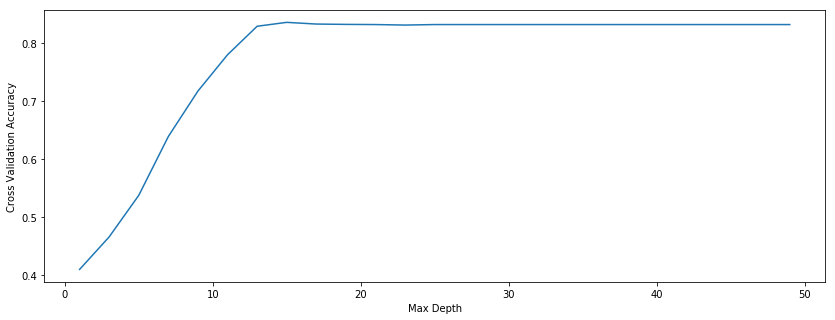

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Max Depth')

Text(0.5, 0, 'Max Depth')

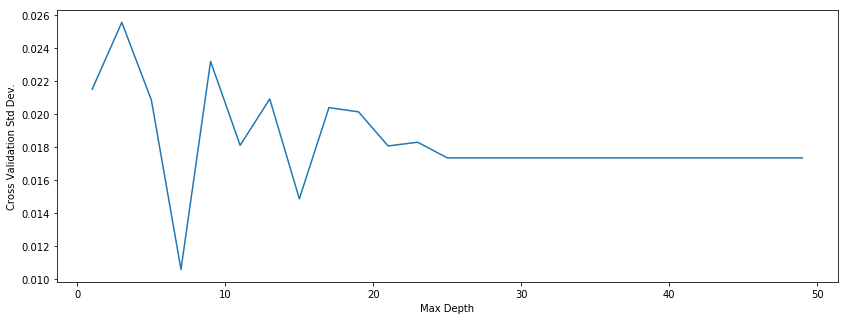

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev.')
plt.xlabel('Max Depth')

#### Model Performance

## Demographic Data

In [11]:
excel_file_demo = 'demographic.xlsx'
demo = pd.read_excel(excel_file_demo,sheet_name=0)
df2 = pd.read_csv('2019_2010_schools_progress.csv')
demo = pd.merge(demo, df2, on='DBN')

In [13]:
demo.head()

,DBN,District,School Name,Year,Total Enrollment,Grade PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,# Female,...,% English Language Learners,# Poverty,% Poverty,Economic Need Index,DISTRICT,SCHOOL,PRINCIPAL,PROGRESS REPORT TYPE,SCHOOL LEVEL*,PEER INDEX*,2009-2010 OVERALL GRADE,2009-2010 OVERALL SCORE,2009-2010 ENVIRONMENT CATEGORY SCORE,2009-2010 ENVIRONMENT GRADE,2009-2010 PERFORMANCE CATEGORY SCORE,2009-2010 PERFORMANCE GRADE,2009-2010 PROGRESS CATEGORY SCORE,2009-2010 PROGRESS GRADE,2009-2010 ADDITIONAL CREDIT,2008-09 PROGRESS REPORT GRADE
0,01M015,1,P.S. 015 Roberto Clemente,2014-15,183,18,27,47,31,19,17,24,0,0,0,0,0,0,0,84,...,0.092896,169,0.923497,0.929921,1,P.S. 015 Roberto Clemente,Thomas Staebell,EMS,Elementary,62.65,C,37.6,7.2,B,3.0,D,27.4,B,0.0,B
1,01M015,1,P.S. 015 Roberto Clemente,2015-16,176,14,32,33,39,23,17,18,0,0,0,0,0,0,0,83,...,0.090909,149,0.846591,0.888513,1,P.S. 015 Roberto Clemente,Thomas Staebell,EMS,Elementary,62.65,C,37.6,7.2,B,3.0,D,27.4,B,0.0,B
2,01M015,1,P.S. 015 Roberto Clemente,2016-17,178,17,28,33,27,31,24,18,0,0,0,0,0,0,0,83,...,0.067416,152,0.853933,0.882354,1,P.S. 015 Roberto Clemente,Thomas Staebell,EMS,Elementary,62.65,C,37.6,7.2,B,3.0,D,27.4,B,0.0,B
3,01M015,1,P.S. 015 Roberto Clemente,2017-18,190,17,28,32,33,23,31,26,0,0,0,0,0,0,0,99,...,0.042105,161,0.847368,0.889605,1,P.S. 015 Roberto Clemente,Thomas Staebell,EMS,Elementary,62.65,C,37.6,7.2,B,3.0,D,27.4,B,0.0,B
4,01M015,1,P.S. 015 Roberto Clemente,2018-19,174,13,20,33,30,30,20,28,0,0,0,0,0,0,0,85,...,0.045977,145,0.833333,0.879787,1,P.S. 015 Roberto Clemente,Thomas Staebell,EMS,Elementary,62.65,C,37.6,7.2,B,3.0,D,27.4,B,0.0,B


### Modelling

In [26]:
features = (['District', '% Asian','% Black','% Multiple Race Categories Not Represented', '% White', '% Poverty' ]
           )

model_df = demo[(features + ['2009-2010 OVERALL GRADE'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['2009-2010 OVERALL GRADE'], test_size=0.1,
    random_state=random_state)

train_df['2009-2010 OVERALL GRADE'] = y_train
holdout_df['2009-2010 OVERALL GRADE'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

# print(train_df.shape[0], train_df['2009-2010 OVERALL GRADE'].mean())
# print(holdout_df.shape[0], holdout_df['2009-2010 OVERALL GRADE'].mean())

In [27]:
k_fold = KFold(n_splits=5, random_state=random_state)


In [28]:
def get_class_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, '2009-2010 OVERALL GRADE'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, '2009-2010 OVERALL GRADE'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)

In [29]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_class_results(logreg)

(0.40745902321857486, 0.014510932191919694)

In [30]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=5
)

get_class_results(dtree)

(0.43739913530824664, 0.015248016818076643)

In [31]:
rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_class_results(rforest)

(0.4719796317053643, 0.01688758117944394)

### Another Attempt

In [214]:
data_2014 = './quality/2014_2015_quality.xlsx'
data_2015 = './quality/2015_2016_quality.xlsx'
network = 'network.xlsx'
quality_2014 = pd.read_excel(data_2014,sheet_name=0)
quality_2015 = pd.read_excel(data_2015,sheet_name=0)
network = pd.read_excel(network,sheet_name=0)

frames = [quality_2014,quality_2015]
quality = pd.concat(frames)
quality_2015.columns

Index(['DBN', 'District', 'School Name', 'Unnamed: 3',
       'Metric Value - Four-Year College Readiness Index',
       'Percent English Language Learners',
       'Percent Students with Disabilities', 'Percent Self-Contained',
       'Economic Need Index', 'Percent in Temp Housing - 4yr',
       'Percent HRA Eligible', 'Percent Asian', 'Percent Black',
       'Percent Hispanic', 'Percent White',
       'Years of principal experience at this school',
       'Percent of teachers with 3 or more years of experience',
       'Student Attendance Rate', 'Percent of Students Chronically Absent',
       'Teacher Attendance Rate', 'Metric Rating - Graduation Rate, 4 year',
       'Metric Value - Graduation Rate, 4 year',
       'Metric Score - Graduation Rate, 4 year',
       'Metric Rating - Graduation Rate, 6 year',
       'Metric Value - Graduation Rate, 6 year',
       'Metric Score - Graduation Rate, 6 year'],
      dtype='object')

In [215]:
quality_2014.columns
df_new = pd.merge(quality,network,on='DBN')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766 entries, 0 to 765
Data columns (total 43 columns):
DBN                                                       766 non-null object
District                                                  766 non-null int64
Economic Need Index                                       766 non-null float64
Metric Rating - Graduation Rate, 4 year                   700 non-null object
Metric Rating - Graduation Rate, 6 year                   649 non-null object
Metric Score - Graduation Rate, 4 year                    700 non-null float64
Metric Score - Graduation Rate, 6 year                    649 non-null float64
Metric Value - Four-Year College Readiness Index          700 non-null float64
Metric Value - Graduation Rate, 4 year                    700 non-null float64
Metric Value - Graduation Rate, 6 year                    649 non-null float64
Percent Asian                                             766 non-null float64
Percent Black                  

In [216]:
df_new.replace('N/A', np.nan)

df_new = df_new.dropna(subset=['Metric Value - Four-Year College Readiness Index','Metric Value - Graduation Rate, 4 year','Metric Rating - Graduation Rate, 4 year','Metric Score - Graduation Rate, 4 year','Metric Rating - Graduation Rate, 6 year','Metric Value - Graduation Rate, 6 year','Metric Score - Graduation Rate, 6 year', 'Percent of teachers with 3 or more years of experience'])

In [217]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649 entries, 0 to 763
Data columns (total 43 columns):
DBN                                                       649 non-null object
District                                                  649 non-null int64
Economic Need Index                                       649 non-null float64
Metric Rating - Graduation Rate, 4 year                   649 non-null object
Metric Rating - Graduation Rate, 6 year                   649 non-null object
Metric Score - Graduation Rate, 4 year                    649 non-null float64
Metric Score - Graduation Rate, 6 year                    649 non-null float64
Metric Value - Four-Year College Readiness Index          649 non-null float64
Metric Value - Graduation Rate, 4 year                    649 non-null float64
Metric Value - Graduation Rate, 6 year                    649 non-null float64
Percent Asian                                             649 non-null float64
Percent Black                  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766 entries, 0 to 765
Data columns (total 42 columns):
DBN                                                       766 non-null object
District                                                  766 non-null int64
Economic Need Index                                       766 non-null float64
Metric Rating - Graduation Rate, 4 year                   700 non-null object
Metric Rating - Graduation Rate, 6 year                   649 non-null object
Metric Score - Graduation Rate, 4 year                    700 non-null float64
Metric Score - Graduation Rate, 6 year                    649 non-null float64
Metric Value - Graduation Rate, 4 year                    700 non-null float64
Metric Value - Graduation Rate, 6 year                    649 non-null float64
Percent Asian                                             766 non-null float64
Percent Black                                             766 non-null float64
Percent English Language Learne

In [220]:
target = 'Metric Value - Four-Year College Readiness Index'

In [225]:
# features = (['Student Attendance Rate'])

features = (['District','Percent Asian','Percent White', 'Percent Black','Percent Hispanic','Economic Need Index'])

##features = (['ghSchool Network Location Code'])

model_df = df_new[(features + [target])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df[target], test_size=0.1,
    random_state=random_state)

train_df[target] = y_train
holdout_df[target] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df[target].mean())
print(holdout_df.shape[0], holdout_df[target].mean())




584 0.3424109589041099
65 0.3688153846153847


In [190]:
df_new.cov()

,District,Economic Need Index,"Metric Score - Graduation Rate, 4 year","Metric Score - Graduation Rate, 6 year","Metric Value - Graduation Rate, 4 year","Metric Value - Graduation Rate, 6 year",Percent Asian,Percent Black,Percent English Language Learners,Percent HRA Eligible,Percent Hispanic,Percent Self-Contained,Percent Students with Disabilities,Percent White,Percent in Temp Housing - 4yr,Percent of Students Chronically Absent,Percent of teachers with 3 or more years of experience,Student Attendance Rate,Teacher Attendance Rate,Unnamed: 3,Years of principal experience at this school,Borough Block Lot,Census Tract,Community District,Council District,Geographical District Code,Administrative District Code,Administrative District Name,ghSchool Network Location Code,Latitude,Longitude
District,8.504898e+01,-4.814028e-01,2.640057e-03,1.439615e-01,0.029467,0.036264,3.445780e-01,3.463381e-01,-0.024790,-4.584677e-01,-8.037273e-01,1.023864e-02,-1.240178e-01,1.025067e-01,-1.728585e-01,-2.097948e-01,1.750135e-01,6.031070e-02,-1.081162e-02,NaN,-1.655847e+00,8.986690e+09,1.599570e+05,9.579636e+02,9.530994e+01,8.493275e+01,8.504898e+01,NaN,-1.389331e+00,-3.487712e-01,3.329044e-01
Economic Need Index,-4.814028e-01,2.454291e-02,-5.879060e-02,-6.924474e-02,-0.013295,-0.011775,-1.135322e-02,1.464460e-03,0.013003,1.918914e-02,2.358158e-02,1.002767e-03,4.842700e-03,-1.223946e-02,7.639512e-03,1.594899e-02,-6.272792e-03,-5.321451e-03,-9.204669e-05,NaN,-2.447491e-02,-5.110323e+07,-8.444202e+02,-5.813064e+00,-2.687216e-01,-4.764684e-01,-4.814028e-01,NaN,1.061063e-01,4.420981e-03,-9.974514e-04
"Metric Score - Graduation Rate, 4 year",2.640057e-03,-5.879060e-02,9.937671e-01,7.095907e-01,0.127816,0.080488,3.384771e-02,-2.432857e-02,-0.041057,-4.935916e-02,-4.566818e-02,-1.076326e-02,-2.406537e-02,3.166419e-02,-2.253422e-02,-8.186583e-02,-1.356094e-02,3.070818e-02,2.485218e-03,NaN,4.888151e-01,-2.994817e+07,4.691486e+02,-1.146780e+00,-1.644753e-01,-2.855733e-02,2.640057e-03,NaN,-7.946417e-02,-4.255207e-03,-5.605197e-03
"Metric Score - Graduation Rate, 6 year",1.439615e-01,-6.924474e-02,7.095907e-01,1.099192e+00,0.107375,0.112881,4.058326e-02,-1.642616e-02,-0.051350,-5.965695e-02,-6.361049e-02,-9.514841e-03,-2.634818e-02,3.430158e-02,-2.724626e-02,-8.458511e-02,3.962865e-03,3.069693e-02,1.658269e-03,NaN,3.891912e-01,-2.901839e+07,-9.655233e+02,-2.686051e-01,-7.222429e-01,1.092962e-01,1.439615e-01,NaN,-3.611617e-01,-1.471608e-03,-1.432778e-03
"Metric Value - Graduation Rate, 4 year",2.946668e-02,-1.329466e-02,1.278160e-01,1.073749e-01,0.021780,0.015712,8.319759e-03,-7.730992e-03,-0.008638,-1.106298e-02,-9.004137e-03,-1.956630e-03,-5.654650e-03,7.564643e-03,-5.482001e-03,-1.714041e-02,4.847453e-04,6.356000e-03,3.676499e-04,NaN,8.126972e-02,-4.391885e+05,-2.195584e+02,2.784922e-01,-9.858491e-02,2.450447e-02,2.946668e-02,NaN,-5.081135e-02,-1.231713e-03,-1.438855e-03
"Metric Value - Graduation Rate, 6 year",3.626435e-02,-1.177490e-02,8.048816e-02,1.128813e-01,0.015712,0.015580,7.379386e-03,-5.702555e-03,-0.007606,-9.749732e-03,-8.799370e-03,-1.540905e-03,-4.924957e-03,6.392023e-03,-4.889770e-03,-1.418968e-02,2.053118e-03,5.213630e-03,2.106176e-04,NaN,5.049009e-02,-5.144425e+05,-2.912211e+02,3.022958e-01,-1.425748e-01,3.175155e-02,3.626435e-02,NaN,-6.926644e-02,-8.704760e-04,-7.169743e-04
Percent Asian,3.445780e-01,-1.135322e-02,3.384771e-02,4.058326e-02,0.008320,0.007379,2.045311e-02,-1.471263e-02,0.000937,-1.106199e-02,-1.264731e-02,-5.865779e-04,-6.151204e-03,6.369816e-03,-2.889489e-03,-1.193427e-02,4.333289e-03,3.918773e-03,5.969548e-05,NaN,-1.157360e-02,4.376118e+07,4.255003e+02,4.091590e+00,1.348008e-02,3.452221e-01,3.445780e-01,NaN,-3.506222e-02,-2.005185e-03,1.072456e-03
Percent Black,3.463381e-01,1.464460e-03,-2.432857e-02,-1.642616e-02,-0.007731,-0.005703,-1.471263e-02,6.120800e-02,-0.015487,4.029562e-03,-3.436249e-02,6.586787e-04,5.950012e-03,-1.216171e-02,-5.088989e-04,9.814805e-03,-1.603734e-03,-3.630908e-03,-1.471043e-04,NaN,-1.351926e-03,4.88

In [202]:
k_fold = KFold(n_splits=5, random_state=random_state)

In [203]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, target])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = mean_squared_error(train_df.loc[test,target], y_predicted)
        results.append(accuracy)
        print(classifier.score(train_df.loc[train, features],train_df.loc[train, target]))
    
    return np.mean(results), np.std(results)

In [226]:
reg = LinearRegression()
get_cv_results(reg)


0.639521541271913
0.6382425683501187
0.6571618505510562
0.6319258580123496
0.6288292049957944


(0.024533627694150104, 0.0012630350462642093)